In [6]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from hamiltonian import *
from parameters import *

from numgrid import angular_grid

# Convert stiffness matrix to correct coordinate system & SI units
C_diamond = rotate_tensor( C_diamond, np.array([0,0,1]), np.pi/4, 4)
C_diamond = rotate_tensor( C_diamond, np.array([0,1,0]), -np.arccos(1/np.sqrt(3)), 4)*1e9

# Convert strain susceptibility to SI units
P = P*h_GHz

Convergence of phonon cross-section parameters $\chi^R$ with respect to number of points in numerical integration

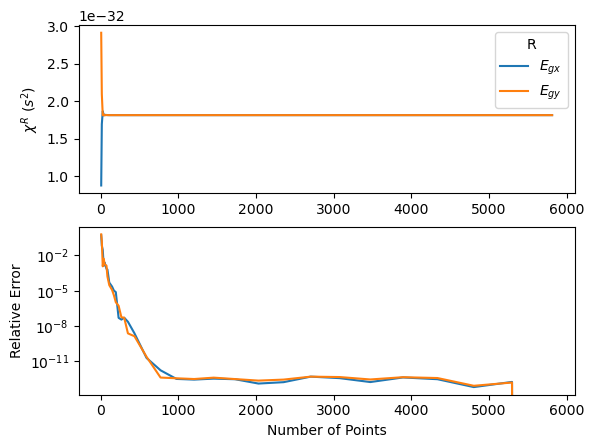

In [7]:
# Calculate chi for different Lebedev quadrature orders
orders = [6, 14, 26, 38, 50, 74, 86, 110, 146, 170, 194, 230, 266, 302, 350, 434, 590, 770, 974, 1202, 1454, 1730, 2030, 2354, 2702, 3074, 3470, 3890, 4334, 4802, 5294, 5810] # Lebedev orders

chiR = []
for n in orders:

    # Get Lebedev quadrature points & weights
    k, w = angular_grid(n)
    k = np.array(k)

    # Calculate speed of sound & displacement modes
    M = np.einsum( "ijkl, ...j, ...k-> ...il", C_diamond, k, k)/rho_diamond/1e3
    omega_square, q = np.linalg.eigh( M )
    c = np.sqrt(omega_square) # [m/s] with indices [k point, mode]

    # Calculate phonon cross-sections
    chiR.append( calculate_chiR(P, k, q, c, rho_diamond*1e3, w) )

chiR = np.array(chiR)

plt.subplot(2,1,1)
plt.plot(orders, chiR[:,0,:])
plt.ylabel(r'$\chi^R$ ($s^2$)')
plt.legend([r'$E_{gx}$', r'$E_{gy}$'], title='R')

plt.subplot(2,1,2)
plt.semilogy(orders, np.abs(chiR[-1,0,:]-chiR[:,0,:])/np.abs(chiR[-1,0,:]))
plt.ylabel("Relative Error")
plt.xlabel("Number of Points")
plt.show()

Effect of uncertainty of strain suseptiblities on $\chi^R$ parameters

In [8]:
# Calculate chi with uncertainties
chiR_err = []
for delta in [-1, 0, 1]:
    
    P_err = [
    np.array([
        [[ d[i] + delta*d_err[i]  ,     0  , (f[i] + delta*f_err[i])/2],
         [    0  , -(d[i] + delta*d_err[i])  ,    0  ],
         [ (f[i] + delta*f_err[i])/2,     0  ,    0  ] ],
        [[    0  , -(d[i] + delta*d_err[i])  ,    0  ],
         [-(d[i] + delta*d_err[i])  ,     0  , (f[i] + delta*f_err[i])/2],
         [   0  ,  (f[i] + delta*f_err[i])/2,    0  ] ]
    ])
    for i in range(len(d))]
    P_err = np.array(P_err)*h_GHz

    chiR_err.append(
        calculate_chiR(P_err, k, q, c, rho_diamond, w)
    )

chiR_err = np.array(chiR_err)

print("Low chi:")
print(chiR_err[0,:,:])
print("Nominal chi:")
print(chiR_err[1,:,:])
print("High chi:")
print(chiR_err[2,:,:])

Low chi:
[[1.62877372e-29 1.62877372e-29]
 [1.62877372e-29 1.62877372e-29]
 [4.75762948e-30 4.75762948e-30]]
Nominal chi:
[[1.81228369e-29 1.81228369e-29]
 [1.81228369e-29 1.81228369e-29]
 [6.15725529e-30 6.15725529e-30]]
High chi:
[[2.02863458e-29 2.02863458e-29]
 [2.02863458e-29 2.02863458e-29]
 [7.88529044e-30 7.88529044e-30]]
